In [99]:
import pandas as pd 
import numpy as np 
import matplotlib.pylab as plt
import marshal
import pickle
import datetime as dt
from scipy.interpolate import interp1d

# %matplotlib notebook 
%matplotlib inline 
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 15, 6


In [100]:
import os
elm_keys = dict()
path ='../datastore/paystations/'
for i in os.listdir(path):
    if i.endswith(".d") or i.endswith(".py"): 
        key = i.split('_')[0]
        elm_keys[key] = pickle.load(open(path + i, 'rb'))
        print 'paystation %s loaded' % key

paystation 17066 loaded
paystation 32489 loaded
paystation 32489 loaded
paystation 8005 loaded


In [118]:
import matplotlib.cm as cm
clr = np.linspace(0, 1, len(elm_keys.keys()))

def plot_paystation(data, key, i):
    y = data.flatten()
    x = np.linspace(1, len(y), num=len(y))
    plt.plot(x, y, color=cm.cool(clr[i]))
    plt.ylabel('Parked cars')
    plt.xlabel('Hour')
    plt.title('Density for paystation %s' % key)
    plt.show()
    
def plot_paystation_interp(data, key, i):
    y = data.flatten()
    x = np.linspace(1, len(y), num=len(y))
    f = interp1d(x, y, kind='cubic')
    x_s = np.linspace(0, len(y), num=len(y), endpoint=True)
    plt.plot(x, y, 'o', color=cm.cool(clr[i]))
    plt.plot(x_s, f(x_s), color=cm.cool(clr[i+1]))
    plt.ylabel('Parked cars')
    plt.xlabel('Hour')
    plt.title('Density for paystation %s' % key)
    plt.show()


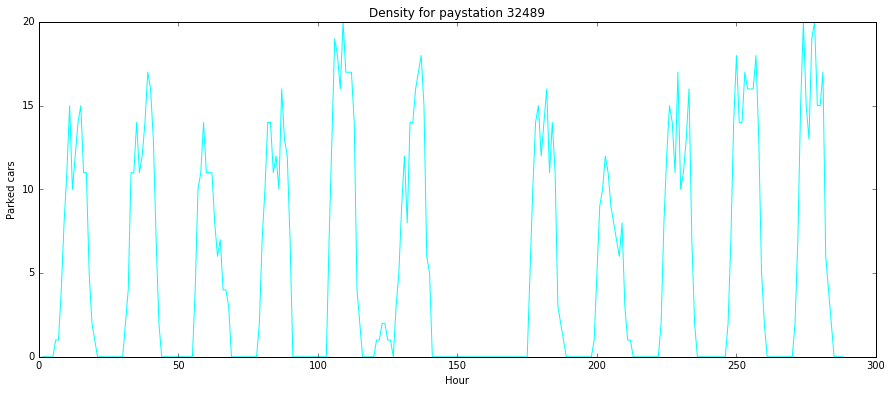

Paystation 32489 popularity = 39405


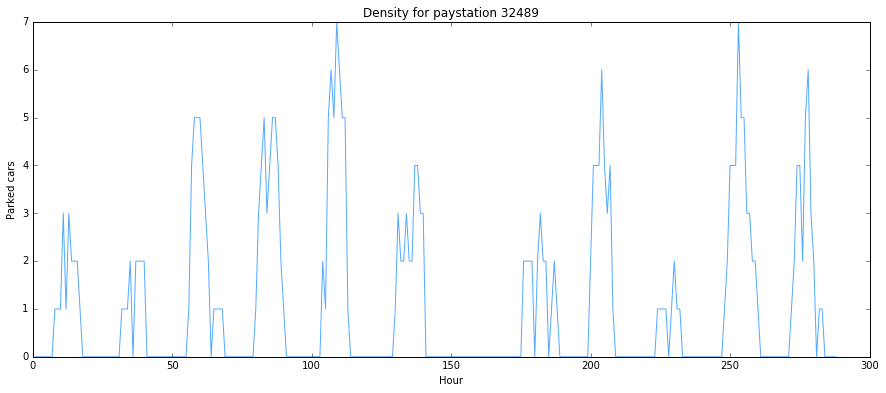

Paystation 32489 popularity = 829


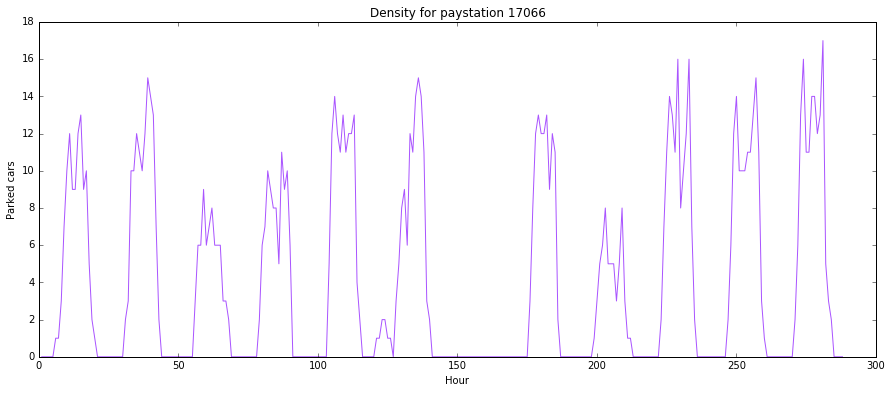

Paystation 17066 popularity = 27985


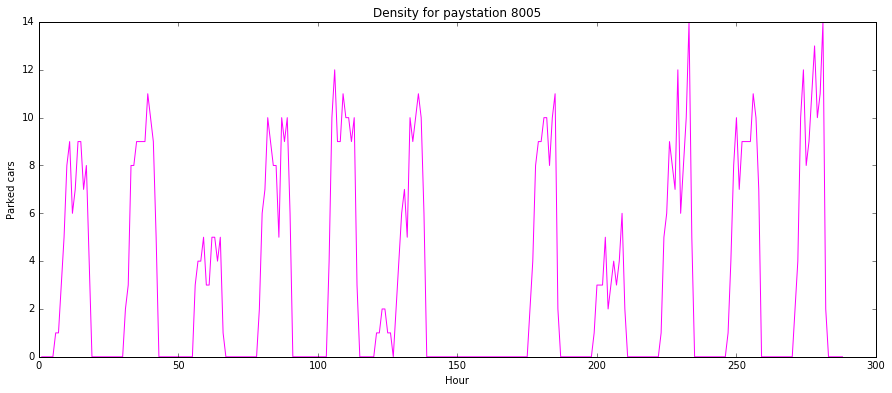

Paystation 8005 popularity = 20483


In [116]:
for i, key in enumerate(elm_keys.keys()):
    data = elm_keys[key]
    data = data[0:12]
    plot_paystation(data, key, i)
    print 'Paystation %s popularity = %d' % (key, np.sum(elm_keys[key]))



## Simple Predictive Model

In [121]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

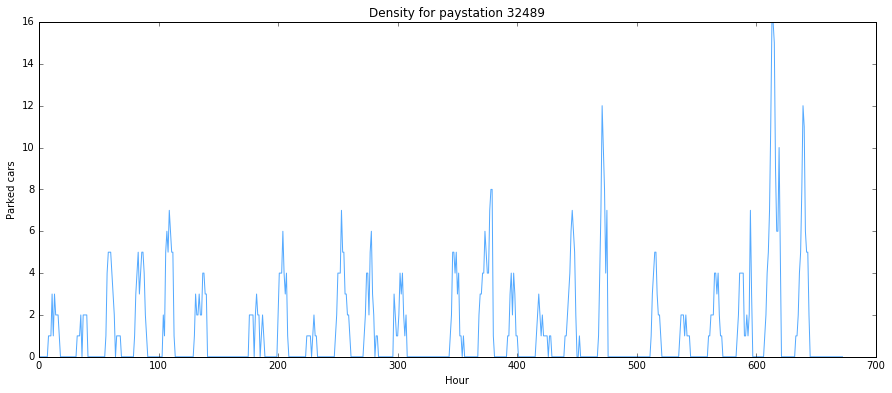

Paystation 32489 popularity = 829


In [120]:
    f = '../datastore/paystations/32489_28_days.d' 
    key = 32489
    elm_keys[key] = pickle.load(open(f, 'rb'))
    
    data = elm_keys[key]
    plot_paystation(data, key, 1)
    print 'Paystation %s popularity = %d' % (key, np.sum(elm_keys[key]))


In [123]:
ts = data.flatten() # make timeseries
sm.stats.durbin_watson(ts)

0.20708571428571429

The value of Durbin-Watson statistic is close to 2 if the errors are uncorrelated. If small, it means that there is a strong evidence that the variable open has high autocorrelation.

### Show Autocorrelation (and partial)

In [132]:
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts, lags = 100, ax=ax2)


### Try some ARMA(2,0) for prediction

In [133]:
arma_mod20 = sm.tsa.ARMA(ts, (2,0)).fit()
print arma_mod20.params

[ 1.2188265   1.02261961 -0.18334427]


In [134]:
print arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic


2047.45195952 2065.49299288 2054.43899263


In [136]:
sm.stats.durbin_watson(arma_mod20.resid)


2.0292613093878464

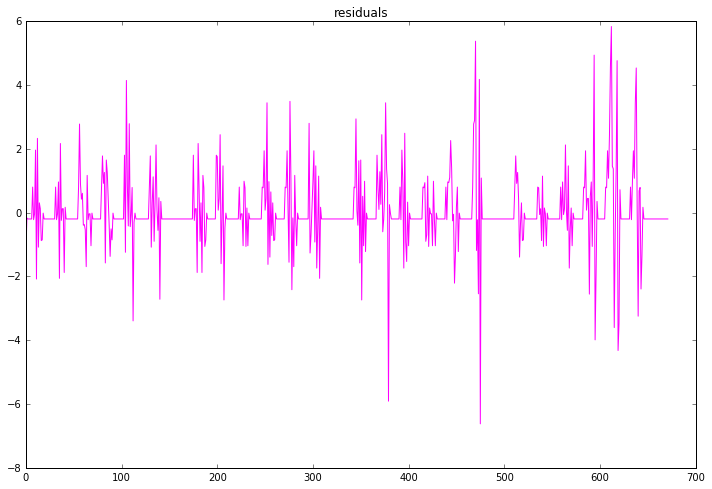

In [143]:
fig = plt.figure(figsize=(12,8))
plt.plot(arma_mod20.resid, color=cm.cool(clr[3]))
plt.title('residuals')


#### Residuals
Calculate the residuals, tests the null hypothesis that the residuals come from a normal distribution, and construct a qq-plot

In [139]:
resid20 = arma_mod20.resid
stats.normaltest(resid20)


NormaltestResult(statistic=138.96208115569283, pvalue=6.6798618417973674e-31)

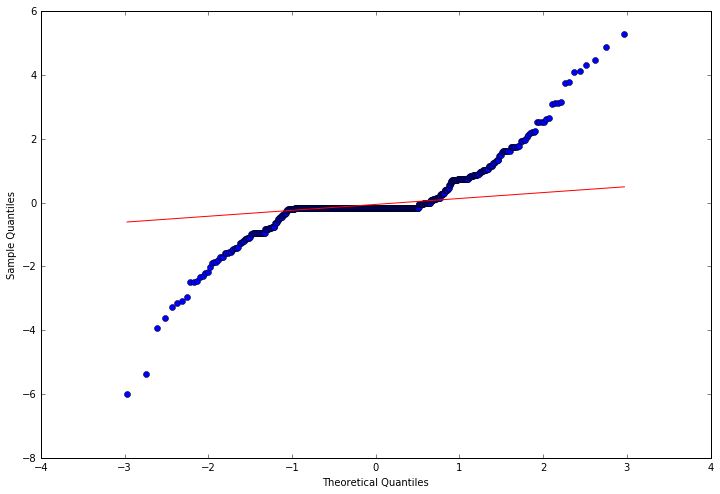

In [144]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid20, line='q', ax=ax, fit=True)

### Autocorrelation of ARMA(2,0)

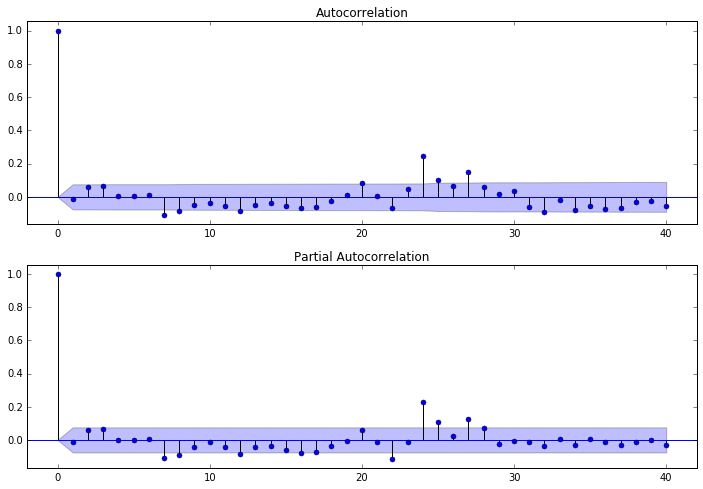

In [145]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid20, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid20, lags=40, ax=ax2)

 calculate the lag, autocorrelation (AC), Q statistic and Prob>Q. Want low Prob(>Q)

In [146]:
r,q,p = sm.tsa.acf(resid20, qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print table.set_index('lag')


           AC           Q      Prob(>Q)
lag                                    
1   -0.015565    0.163527  6.859300e-01
2    0.059212    2.533664  2.817227e-01
3    0.062623    5.188695  1.584901e-01
4    0.002270    5.192189  2.681399e-01
5    0.006808    5.223663  3.891985e-01
6    0.011394    5.311945  5.044704e-01
7   -0.109601   13.493565  6.095771e-02
8   -0.085654   18.497961  1.778783e-02
9   -0.050499   20.240125  1.648697e-02
10  -0.035173   21.086565  2.049797e-02
11  -0.057374   23.342120  1.581063e-02
12  -0.087905   28.644984  4.447038e-03
13  -0.049360   30.319492  4.234952e-03
14  -0.036464   31.234719  5.138876e-03
15  -0.052508   33.135458  4.495478e-03
16  -0.065425   36.090842  2.810591e-03
17  -0.062224   38.768214  1.924921e-03
18  -0.024430   39.181535  2.693923e-03
19   0.013765   39.312953  4.023273e-03
20   0.082072   43.992197  1.508557e-03
21   0.003247   43.999531  2.338498e-03
22  -0.068610   47.279649  1.349267e-03
23   0.044579   48.666567  1.373693e-03
